In [42]:
# Add parent directory to sys.path so we can import wikipedia_downloader.py
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
sys.path.append(os.path.abspath(os.getcwd()))

In [43]:
# Import the Wikipedia downloader module
from wikipedia_downloader import download_wikipedia_to_markdown, get_page_title_from_url

# Example usage: Download a Wikipedia page
wikipedia_url = "https://en.wikipedia.org/wiki/Artificial_intelligence"
output_file = "downloads/artificial_intelligence.md"

import os

if not os.path.exists(output_file):
    # Download the page
    print (f"Downloading Wikipedia page from {wikipedia_url} to {output_file}...")
    success = download_wikipedia_to_markdown(wikipedia_url, output_file)
    if success:
        print(f"Wikipedia page downloaded successfully!")
        
        # Read and display first 500 characters of the downloaded content
        with open(output_file, 'r', encoding='utf-8') as f:
            content = f.read()
            print(f"\nFirst 500 characters of the downloaded content:")
            print(content[:500] + "..." if len(content) > 500 else content)
    else:
        print("Failed to download Wikipedia page")
else:
    print(f"File '{output_file}' already exists. Skipping download.")
    success = True


File 'downloads/artificial_intelligence.md' already exists. Skipping download.


In [44]:
# if not exists create a Now after we downloaded the file generate another one reduced that does not break markdown section delimited by # starting line but it is no longer than 300 rows

# generate name of reduced file appending _reduced to the original file name
reduced_file_name = os.path.splitext(output_file)[0] + "_reduced.md"
if not os.path.exists(reduced_file_name):
    print(f"Generating reduced file: {reduced_file_name}...")
    with open(output_file, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    
    print (f"Total lines in the original file: {len(lines)}")
    # Reduce to 300 lines, ensuring we don't break markdown sections
    reduced_lines = []
    count = 0
    for line in lines:
        count += 1
        if line.startswith('#') and count >= 300:
            break
        reduced_lines.append(line)
        
    with open(reduced_file_name, 'w', encoding='utf-8') as f:
        f.writelines(reduced_lines)
    
    print(f"Reduced file created successfully: {reduced_file_name}")


# Semantic Chunking with LlamaIndex

This notebook demonstrates how to use LlamaIndex's semantic chunking to intelligently split PDF documents based on semantic similarity rather than fixed chunk sizes.

Semantic chunking adaptively picks breakpoints between sentences using embedding similarity, ensuring chunks contain semantically related content.

In [45]:
# Import required libraries
import os
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex
from llama_index.core.node_parser import SentenceSplitter, SemanticSplitterNodeParser
from llama_index.embeddings.openai import OpenAIEmbedding

In [46]:
from dotenv import load_dotenv
import os
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding

load_dotenv()

api_key = os.environ.get('OPENAI_API_KEY')
azure_endpoint = os.environ.get('OPENAI_API_BASE')
deployment_name = os.environ.get('LLAMAINDEX_DEPLOYMENT_NAME')
api_version = "2024-02-15-preview"

In [47]:
from llama_index.core import Document

# Load with default behavior (one doc per page)
documents = SimpleDirectoryReader(input_files=[reduced_file_name]).load_data()

print(f"Loaded {len(documents)} document(s)")
print(f"Document content preview: {documents[0].text[:1000]}...")

Loaded 1 document(s)
Document content preview: Intelligence of machines

"AI" redirects here. For other uses, see AI (disambiguation) and Artificial intelligence (disambiguation).

**Artificial intelligence** (**AI**) is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making. It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals.

High-profile applications of AI include advanced web search engines (e.g., Google Search); recommendation systems (used by YouTube, Amazon, and Netflix); virtual assistants (e.g., Google Assistant, Siri, and Alexa); autonomous vehicles (e.g., Waymo); generative and creative tools (e.g., language models and AI art); and superhuman play and analy

### Key points:

No built-in max token/character parameter: The SemanticSplitterNodeParser does not currently expose a parameter to set a hard maximum chunk size in tokens or characters.

Known limitation: This is a recognized issue in the LlamaIndex community, and users have reported that chunks exceeding model limits can cause errors during embedding or inference.

Workarounds:

- Custom subclassing: You can subclass SemanticSplitterNodeParser to add a post-processing step that checks chunk sizes and further splits any that exceed your desired limit. Example approaches and code snippets for this workaround are provided by the community.

- Safety net pattern: One common pattern is to use a secondary, simpler splitter (e.g., SentenceSplitter) as a fallback to break up oversized chunks after semantic splitting

In [48]:
embed_model = AzureOpenAIEmbedding(
    model="text-embedding-3-small",
    deployment_name="text-embedding-3-small",
    api_key=api_key,
    azure_endpoint=azure_endpoint,
    api_version=api_version,
)

# Configure semantic splitter
splitter = SemanticSplitterNodeParser(
    buffer_size=1,  # Number of sentences to group together when evaluating semantic similarity
    breakpoint_percentile_threshold=90,  # Percentile threshold for determining breakpoints
    embed_model=embed_model
)

# Create baseline splitter for comparison
base_splitter = SentenceSplitter(chunk_size=512)

In [49]:
# Generate semantic chunks
print("Generating semantic chunks...")
semantic_nodes = splitter.get_nodes_from_documents(documents, show_progress=True)

print("Generating baseline chunks...")
baseline_nodes = base_splitter.get_nodes_from_documents(documents, show_progress=True)

print(f"Semantic chunking produced {len(semantic_nodes)} chunks")
print(f"Baseline chunking produced {len(baseline_nodes)} chunks")

Generating semantic chunks...


Parsing nodes: 100%|██████████| 1/1 [00:11<00:00, 11.37s/it]


Generating baseline chunks...


Parsing nodes: 100%|██████████| 1/1 [00:00<00:00, 76.75it/s]

Semantic chunking produced 31 chunks
Baseline chunking produced 29 chunks


## Inspecting Semantic Chunks

Let's examine the first few chunks created by semantic chunking to see how they group semantically related content.

In [50]:
# Display first few semantic chunks
for i, node in enumerate(semantic_nodes[:3]):
    print(f"\n=== Semantic Chunk {i+1} ===")
    print(f"Length: {len(node.get_content())} characters")
    print(f"Content preview: {node.get_content()[:1000]}...")
    print("-" * 50)


=== Semantic Chunk 1 ===
Length: 3070 characters
Content preview: Intelligence of machines

"AI" redirects here. For other uses, see AI (disambiguation) and Artificial intelligence (disambiguation).

**Artificial intelligence** (**AI**) is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making. It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals.

High-profile applications of AI include advanced web search engines (e.g., Google Search); recommendation systems (used by YouTube, Amazon, and Netflix); virtual assistants (e.g., Google Assistant, Siri, and Alexa); autonomous vehicles (e.g., Waymo); generative and creative tools (e.g., language models and AI art); and super

## Comparing with Baseline Chunking

Now let's compare the semantic chunks with baseline fixed-size chunks to see the difference in content organization.

In [51]:
# Display first few baseline chunks for comparison
for i, node in enumerate(baseline_nodes[:3]):
    print(f"\n=== Baseline Chunk {i+1} ===")
    print(f"Length: {len(node.get_content())} characters")
    print(f"Content preview: {node.get_content()[:300]}...")
    print("-" * 50)


=== Baseline Chunk 1 ===
Length: 2552 characters
Content preview: Intelligence of machines

"AI" redirects here. For other uses, see AI (disambiguation) and Artificial intelligence (disambiguation).

**Artificial intelligence** (**AI**) is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, r...
--------------------------------------------------

=== Baseline Chunk 2 ===
Length: 2649 characters
Content preview: [a] To reach these goals, AI researchers have adapted and integrated a wide range of techniques, including search and mathematical optimization, formal logic, artificial neural networks, and methods based on statistics, operations research, and economics.[b] AI also draws upon psychology, linguistic...
--------------------------------------------------

=== Baseline Chunk 3 ===
Length: 2696 characters
Content preview: These consist of particular traits or capabilities that researchers expect an intelligent sys

In [52]:
# Analyze chunk size distribution
semantic_sizes = [len(node.get_content()) for node in semantic_nodes]
baseline_sizes = [len(node.get_content()) for node in baseline_nodes]

print("Chunk Size Statistics:")
print(f"Semantic chunks - Min: {min(semantic_sizes)}, Max: {max(semantic_sizes)}, Avg: {sum(semantic_sizes)/len(semantic_sizes):.1f}")
print(f"Baseline chunks - Min: {min(baseline_sizes)}, Max: {max(baseline_sizes)}, Avg: {sum(baseline_sizes)/len(baseline_sizes):.1f}")

Chunk Size Statistics:
Semantic chunks - Min: 59, Max: 6767, Avg: 1464.9
Baseline chunks - Min: 1987, Max: 2752, Avg: 2476.2


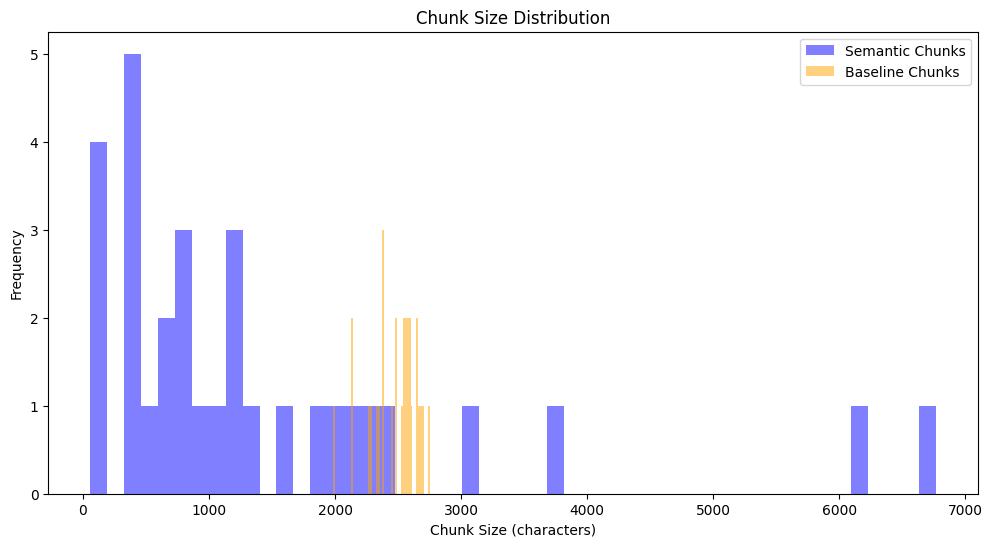

In [53]:
# Now plot the distribution of chunk sizes
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.hist(semantic_sizes, bins=50, alpha=0.5, label='Semantic Chunks', color='blue')
plt.hist(baseline_sizes, bins=50, alpha=0.5, label='Baseline Chunks', color='orange')
plt.title('Chunk Size Distribution')
plt.xlabel('Chunk Size (characters)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [55]:
# Now print the shortest 10 semantic chunks
shortest_semantic_chunks = sorted(semantic_nodes, key=lambda x: len(x.get_content()))[:10]
print("\n=== Shortest 10 Semantic Chunks ===")
for i, node in enumerate(shortest_semantic_chunks):
    print(f"\n=== Shortest Semantic Chunk {i+1} ===")
    print(f"Length: {len(node.get_content())} characters")
    print(f"Content preview: {node.get_content()[:300]}...")
    print("-" * 50)


=== Shortest 10 Semantic Chunks ===

=== Shortest Semantic Chunk 1 ===
Length: 59 characters
Content preview: Computer vision is the ability to analyze visual input.

...
--------------------------------------------------

=== Shortest Semantic Chunk 2 ===
Length: 75 characters
Content preview: They can be fine-tuned based on chosen examples using supervised learning. ...
--------------------------------------------------

=== Shortest Semantic Chunk 3 ===
Length: 84 characters
Content preview: Classifiers are functions that use pattern matching to determine the closest match. ...
--------------------------------------------------

=== Shortest Semantic Chunk 4 ===
Length: 177 characters
Content preview: "Heuristics" or "rules of thumb" can help prioritize choices that are more likely to reach a goal.

Adversarial search is used for game-playing programs, such as chess or Go. ...
--------------------------------------------------

=== Shortest Semantic Chunk 5 ===
Length: 368 characte

In [57]:
# now print the longest chunk
longest_semantic_chunk = max(semantic_nodes, key=lambda x: len(x.get_content()))
print("\n=== Longest Semantic Chunk ===")
print(f"Length: {len(longest_semantic_chunk.get_content())} characters")
print(f"Content: {longest_semantic_chunk.get_content()}...")


=== Longest Semantic Chunk ===
Length: 6767 characters
Content: The reason that deep learning performs so well in so many applications is not known as of 2021. The sudden success of deep learning in 2012–2015 did not occur because of some new discovery or theoretical breakthrough (deep neural networks and backpropagation had been described by many people, as far back as the 1950s)[i] but because of two factors: the incredible increase in computer power (including the hundred-fold increase in speed by switching to GPUs) and the availability of vast amounts of training data, especially the giant curated datasets used for benchmark testing, such as ImageNet.[j]

### GPT

Generative pre-trained transformers (GPT) are large language models (LLMs) that generate text based on the semantic relationships between words in sentences. Text-based GPT models are pre-trained on a large corpus of text that can be from the Internet. The pretraining consists of predicting the next token (a token being 

## Setting up Query Engines

We'll create query engines for both chunking methods to test their effectiveness in retrieving relevant information.

In [32]:
from llama_index.core import Settings
from llama_index.core.response.notebook_utils import display_source_node

# Configure both embedding model and LLM in global settings
Settings.embed_model = embed_model

llm = AzureOpenAI(
    model="gpt-4o-mini",
    deployment_name=deployment_name,
    api_key=api_key,
    azure_endpoint=azure_endpoint,
    api_version=api_version,
    engine=deployment_name
)

Settings.llm = llm

# Create vector indexes and query engines
semantic_index = VectorStoreIndex(semantic_nodes)
semantic_query_engine = semantic_index.as_query_engine()

baseline_index = VectorStoreIndex(baseline_nodes)
baseline_query_engine = baseline_index.as_query_engine()

print("Query engines created successfully!")

Query engines created successfully!


## Testing Queries

Let's test both chunking approaches with sample queries to see how they perform.

In [33]:
test_query = "Does Artificial intelligence can be used for bad thing?"

print("=== Semantic Chunking Response ===")
semantic_response = semantic_query_engine.query(test_query)
print(semantic_response)

print("\n" + "="*50)
print("=== Baseline Chunking Response ===")
baseline_response = baseline_query_engine.query(test_query)
print(baseline_response)

=== Semantic Chunking Response ===
Yes, artificial intelligence can be used for harmful purposes. The development and application of AI technologies can lead to unintended consequences and ethical concerns, prompting discussions about regulatory policies to ensure the safety and benefits of the technology.

=== Baseline Chunking Response ===
Yes, artificial intelligence can be used for harmful purposes. It has the potential to facilitate cybercrime, deceive or manipulate individuals through fake news or deepfakes, and raise ethical concerns related to privacy and surveillance. Additionally, the use of generative AI can lead to mass job displacement and may violate intellectual property laws.


In [34]:
# Display source nodes for semantic chunking response
print("=== Source Nodes (Semantic Chunking) ===")
for i, node in enumerate(semantic_response.source_nodes):
    print(f"\nNode {i+1} (Similarity: {node.score:.4f}):")
    display_source_node(node, source_length=500)

=== Source Nodes (Semantic Chunking) ===

Node 1 (Similarity: 0.6035):


**Node ID:** 694a0060-b587-4ebb-a131-3cc1c34243a0<br>**Similarity:** 0.6034519404054668<br>**Text:** Intelligence of machines

"AI" redirects here. For other uses, see AI (disambiguation) and Artificial intelligence (disambiguation).

**Artificial intelligence** (**AI**) is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making. It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their envir...<br>


Node 2 (Similarity: 0.5629):


**Node ID:** 5b49408f-9a3c-4321-a2d7-84f4fbf9c677<br>**Similarity:** 0.5628768771568523<br>**Text:** The field includes speech recognition, image classification, facial recognition, object recognition, object tracking, and robotic perception.

### Social intelligence

Kismet, a robot head which was made in the 1990s; it is a machine that can recognize and simulate emotions.

Affective computing is a field that comprises systems that recognize, interpret, process, or simulate human feeling, emotion, and mood. For example, some virtual assistants are programmed to speak conversationally ...<br>

In [35]:
# Display source nodes for baseline chunking response
print("=== Source Nodes (Baseline Chunking) ===")
for i, node in enumerate(baseline_response.source_nodes):
    print(f"\nNode {i+1} (Similarity: {node.score:.4f}):")
    display_source_node(node, source_length=500)

=== Source Nodes (Baseline Chunking) ===

Node 1 (Similarity: 0.6610):


**Node ID:** 203c1e6c-dc99-428a-9944-10c4bdc039f9<br>**Similarity:** 0.6610065897119561<br>**Text:** Artificial intelligence is used in astronomy to analyze increasing amounts of available data and applications, mainly for "classification, regression, clustering, forecasting, generation, discovery, and the development of new scientific insights." For example, it is used for discovering exoplanets, forecasting solar activity, and distinguishing between signals and instrumental effects in gravitational wave astronomy. Additionally, it could be used for activities in space, such as space explor...<br>


Node 2 (Similarity: 0.6254):


**Node ID:** 24ac80aa-5a70-4bd8-bb44-3f1e6e602623<br>**Similarity:** 0.6254404146101963<br>**Text:** Technology companies developing generative AI include OpenAI, Anthropic, Meta AI, Microsoft, Google, DeepSeek, and Baidu.

Generative AI has raised many ethical questions as it can be used for cybercrime, or to deceive or manipulate people through fake news or deepfakes. Even if used ethically, it may lead to mass replacement of human jobs. The tools themselves have been criticized as violating intellectual property laws, since they are trained on copyrighted works.

### Agents

Main ar...<br>

## Advanced Configuration

You can fine-tune the semantic splitter parameters for better results:

- `buffer_size`: Number of sentences to group when evaluating similarity
- `breakpoint_percentile_threshold`: Higher values create larger, more cohesive chunks
- `embed_model`: Different embedding models may produce different chunking results

In [ ]:
# Example of fine-tuning semantic splitter parameters
fine_tuned_splitter = SemanticSplitterNodeParser(
    buffer_size=2,  # Group 2 sentences at a time
    breakpoint_percentile_threshold=90,  # Lower threshold for more granular chunks
    embed_model=embed_model
)

# Generate chunks with fine-tuned parameters
fine_tuned_nodes = fine_tuned_splitter.get_nodes_from_documents(documents)

print(f"Fine-tuned semantic chunking produced {len(fine_tuned_nodes)} chunks")
print(f"Original semantic chunking produced {len(semantic_nodes)} chunks")
print(f"Baseline chunking produced {len(baseline_nodes)} chunks")

## Summary

Semantic chunking offers several advantages over fixed-size chunking:

1. **Content Coherence**: Chunks contain semantically related sentences
2. **Adaptive Size**: Chunk sizes vary based on content structure
3. **Better Retrieval**: More relevant chunks for specific queries
4. **Context Preservation**: Related information stays together

Use semantic chunking when you need more intelligent document segmentation for RAG applications.